In [53]:
%load_ext autoreload
%autoreload 2

import xgboost as xgb
import pandas as pd
import numpy as np
from utils import k_fold_cross_validation_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
df_train = pd.read_csv('data/data_processed_train_merged.csv')
df_test = pd.read_csv('data/data_processed_test_merged.csv')
df = pd.concat((df_train, df_test), ignore_index=True)

string_cols = ['survey_language', 'disability']
df[string_cols] = df[string_cols].astype('category')
df[string_cols] = df[string_cols].apply(lambda x: x.cat.codes)


In [55]:
candidate_cols = [
#      'travel_date_dow',
     'o_purpose_category',
     'd_purpose_category',
#      'num_non_hh_travelers',
#      'num_hh_travelers',
     'num_travelers',
#      'o_location_type',
#      'd_location_type',
#      'o_congestion',
     'd_congestion',
#      'age',
#      'employment',
#      'student',
     'license',
#      'planning_apps',
#      'industry',
#      'gender',
#      'education',
#      'survey_language',
#      'num_bicycles',
     'num_vehicles',
#      'res_type',
     'rent_own',
#      'income_aggregate',
#      'num_people',
#      'num_adults',
#      'num_kids',
#      'num_workers',
#      'num_students',
#      'disability'
#     'trip_distance'
    'res_type_merged',
    'income_aggregate_merged',
    'age_merged',
    'travel_date_dow_merged',
    'education_merged'
]

categorial_columns = ['travel_date_dow', 'o_purpose_category', 'd_purpose_category', 'o_location_type',
                      'd_location_type', 'age', 'employment', 'license', 'planning_apps', 'industry',
                      'gender', 'survey_language', 'res_type', 'rent_own',  'disability']

onehot = pd.get_dummies(df[candidate_cols], columns=[x for x in categorial_columns if x in candidate_cols])

X_train_val = onehot.to_numpy()[:len(df_train)]
group_train_val = df['person_id'].to_numpy()[:len(df_train)]
y_train_val = df['trip_distance'][:len(df_train)]

X_test = onehot.to_numpy()[len(df_train):]


In [56]:
# custom objective: MAPE
def objective_mape(pred, label):
    """
    Returns gradient and hessian of mape. 
    """
    sign = [1 if x > 0 else -1 for x in pred-label]
    sign = np.multiply(sign, [0 if p==l else 1 for p, l in zip(pred, label)])
    return -1/label * sign, np.zeros_like(pred)


pred = [1.1, 10.1, 99.9, 100, 100.1]
label = np.array([1, 10, 100, 100, 100])


In [68]:
model = xgb.XGBRegressor(objective='reg:squarederror', # objective_mape or 'reg:squarederror'
                          n_estimators = 100,
                          n_jobs=-1,
                          random_state=42,
                          use_label_encoder =False)


train_metrics, val_metrics = k_fold_cross_validation_regression(X_train_val,
                                                                y_train_val,
                                                                group_train_val,
                                                                model, 
                                                                weight=1/y_train_val)


In [69]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 3, 1, 4, 2, 5]]
train_metrics_df = pd.DataFrame(metrics, columns=['mse-train', 'mse-val', 'mae-train', 'mae-val', 'mape-train', 'mape-val'])
train_metrics_df

,mse-train,mse-val,mae-train,mae-val,mape-train,mape-val
0,15.007560,17.999256,2.027655,2.323340,0.800244,1.093692
1,15.721355,14.342483,2.086133,2.039567,0.807368,1.189738
2,15.226438,16.490823,2.046345,2.212176,0.799570,1.198340
3,15.432346,16.329696,2.051069,2.230714,0.800529,1.122547
4,15.606425,14.723836,2.083264,2.043523,0.809334,1.084884


In [71]:
model = xgb.XGBRegressor(objective='reg:squarederror', # objective_mape or 'reg:squarederror'
                          n_estimators = 100,
                          n_jobs=-1,
                          random_state=42,
                          use_label_encoder =False)

train_metrics, val_metrics = k_fold_cross_validation_regression(X_train_val, y_train_val, group_train_val, model)


In [72]:
metrics = np.concatenate((train_metrics, val_metrics), axis=1)
metrics = metrics[:,[0, 3, 1, 4, 2, 5]]
train_metrics_df = pd.DataFrame(metrics, columns=['mse-train', 'mse-val', 'mae-train', 'mae-val', 'mape-train', 'mape-val'])
train_metrics_df

,mse-train,mse-val,mae-train,mae-val,mape-train,mape-val
0,8.947659,13.563936,2.028974,2.515704,3.523003,4.087036
1,9.352948,11.758974,2.076680,2.449231,3.542698,4.773484
2,9.079179,12.915725,2.048048,2.452596,3.511593,4.233441
3,9.313115,12.619197,2.075818,2.420289,3.557925,4.092322
4,9.226384,12.067101,2.077049,2.446775,3.589158,4.430369


## Hyperparameter search

In [73]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

distributions = {
    'learning_rate': loguniform(10**-5, 1),
#     'max_depth': [2, 4, 6, 8]
}

k_fold = GroupKFold(n_splits=5)
search = RandomizedSearchCV(model,
                            distributions,
                            random_state=1,
                            n_jobs=4,
                            scoring='neg_mean_absolute_percentage_error', # 'neg_mean_squared_error' or 'neg_mean_absolute_percentage_error'
                            n_iter=10,
                            cv=k_fold
                           ).fit(X_train_val, y_train_val, groups=group_train_val)
print('best parameter', search.best_params_)
print('best score', search.best_score_)


/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/pinyen/opt/anaconda3/envs/da-ml/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated an

best parameter {'learning_rate': 1.0013176560941263e-05}
best score -0.9912994089287441


In [74]:
search.cv_results_

{'mean_fit_time': array([8.17404981, 8.00410686, 8.16080785, 8.0961484 , 8.24558358,
        8.30438638, 8.40590687, 8.35039315, 8.3596581 , 6.57902355]),
 'std_fit_time': array([0.16566037, 0.09196212, 0.13887264, 0.12787675, 0.09511675,
        0.03947901, 0.09197292, 0.16562415, 0.15025809, 2.17353399]),
 'mean_score_time': array([0.01058002, 0.00999055, 0.00940905, 0.00901752, 0.0100698 ,
        0.01134219, 0.01166615, 0.01020651, 0.01070404, 0.00940728]),
 'std_score_time': array([0.00247062, 0.0016376 , 0.00128284, 0.00099346, 0.00078946,
        0.00194344, 0.00194402, 0.00094327, 0.00173572, 0.00109048]),
 'param_learning_rate': masked_array(data=[0.001216494146415184, 0.03995972283135063,
                    1.0013176560941263e-05, 0.00032483503450866794,
                    5.4172571827679706e-05, 2.8952960233492824e-05,
                    8.536916958038756e-05, 0.000534322712559412,
                    0.0009634681692624377, 0.004944059287398676],
              mask=[False

## train model on whole dataset

In [79]:
## model parameter from search results
model = xgb.XGBRegressor(objective='reg:squarederror', # reg:squarederror
                         n_estimators = 100,
                         learning_rate=0.0012, # 0.0779 from hyperparameter search
                         max_depth=4,
                         n_jobs=-1,
                         random_state=42,
                         use_label_encoder =False)

model.fit(X_train_val, y_train_val)

# calculate training metrics
y_train_val_pred = model.predict(X_train_val)
print(mse_mae_mape(y_train_val, y_train_val_pred))

(16.316333949806634, 2.1846737622643517, 1.303820624434615)


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

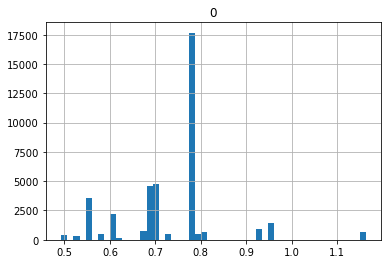

In [83]:
pd.DataFrame(y_train_val_pred).hist(bins=50)

## Read test data


In [163]:
y_train_val_pred = model.predict(X_train_val)
y_test_pred = model.predict(X_test)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

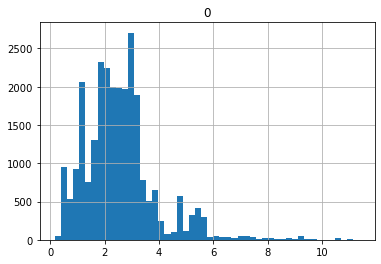

In [164]:
pd.DataFrame(y_test_pred).hist(bins=50)

In [165]:
# Append prediction to dataset
df_train['trip_distance'] = y_train_val_pred
df_test['trip_distance'] = y_test_pred

,Unnamed: 0,id,person_id,trip_n,travel_date,travel_date_dow,o_purpose_category,d_purpose_category,num_non_hh_travelers,num_hh_travelers,...,res_type,rent_own,income_aggregate,num_people,num_adults,num_kids,num_workers,num_students,disability,trip_distance
0,0,39498,1795,0,07/06/2019,5,1,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
1,1,39499,1795,1,07/06/2019,5,6,6,0,1,...,6,2,1,2,2,0,1,1,none,1.060259
2,2,39500,1795,2,07/06/2019,5,6,1,0,1,...,6,2,1,2,2,0,1,1,none,1.635832
3,3,39501,1796,0,05/06/2019,3,1,6,0,1,...,5,2,1,2,1,1,0,2,none,1.205747
4,4,39502,1796,1,05/06/2019,3,6,7,0,1,...,5,2,1,2,1,1,0,2,none,1.039199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26289,26289,65787,2991,48,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26290,26290,65788,2991,49,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26291,26291,65789,2991,50,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874
26292,26292,65790,2991,51,27/06/2019,4,8,8,2,2,...,5,2,2,2,2,0,2,0,none,0.345874


In [166]:
# save test data with trip_distance predictions to file
df_train.to_csv('data/xgboost_distance_regression_train', index=False)
df_test.to_csv('data/xgboost_distance_regression_test', index=False)